In [1]:
%matplotlib inline
from copy import deepcopy
from os.path import abspath
from typing import Dict, Any
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import class_weight
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import xgboost

In [2]:
pd.options.display.max_columns = None

In [3]:
source = abspath("./data.csv")

In [4]:
df = pd.read_csv(source, sep=";")

In [5]:
df.sample(10)

,INCOME,SEX,MARITAL_STATUS,AGE,EDUCATION,OCCUPATION,LIVING_PERIOD,DUAL_INCOMES,PERSONS_COUNT,PERSONS_UNDER_18,HOUSEHOLDER_STATUS,HOME_TYPE,ETHNIC,LANGUAGE
4879,9,2,1.0,4,6.0,1.0,3.0,2,3.0,0,1.0,1.0,7.0,1.0
7687,6,2,2.0,2,4.0,6.0,4.0,2,2.0,0,1.0,1.0,2.0,1.0
3906,7,2,1.0,2,3.0,5.0,NaN,3,4.0,2,1.0,4.0,7.0,1.0
1974,6,2,3.0,4,4.0,4.0,5.0,1,NaN,0,2.0,3.0,5.0,1.0
8735,1,1,5.0,1,2.0,6.0,4.0,1,6.0,4,3.0,1.0,2.0,3.0
7118,1,1,5.0,1,2.0,6.0,5.0,1,7.0,3,3.0,1.0,7.0,NaN
8505,5,1,1.0,3,4.0,4.0,NaN,2,2.0,0,1.0,1.0,2.0,3.0
6118,2,1,3.0,7,5.0,8.0,5.0,1,1.0,0,2.0,4.0,7.0,1.0
4519,5,2,1.0,3,4.0,5.0,NaN,3,4.0,0,1.0,1.0,7.0,1.0
259,6,2,3.0,6,4.0,5.0,5.0,1,4.0,0,1.0,1.0,7.0,1.0


# Вернём значения
Напишем мапперы значений, которые авторы датасета закодировали. Все числовые отрезки заменим числами из этих отрезков, чаще всего на среднее значение.

In [6]:
class SourceValuesTransformer(BaseEstimator, TransformerMixin):
    
    maps = {
        "INCOME": {
            1: 7500.,
            2: 12500.,
            3: 17500.,
            4: 22500.,
            5: 27500.,
            6: 35000.,
            7: 45000.,
            8: 60000.,
            9: 90000.
        },
        "SEX": {
            1: "m",
            2: "f"
        },
        "MARITAL_STATUS": {
            1: "Married",
            2: "Living together, not married",
            3: "Divorced or separated",
            4: "Widowed",
            5: "Single, never married"
        },
        "AGE": {
            1: 16,
            2: 21,
            3: 30,
            4: 40,
            5: 50,
            6: 60,
            7: 75
        },
        "EDUCATION": {
            1: "Grade 8 or less",
            2: "Grades 9 to 11",
            3: "Graduated high school",
            4: "1 to 3 years of college",
            5: "College graduate",
            6: "Grad Study",
        },
        "OCCUPATION": {
            1: "Professional/Managerial",
            2: "Sales Worker",
            3: "Factory Worker/Laborer/Driver",
            4: "Clerical/Service Worker",
            5: "Homemaker",
            6: "Student, HS or College",
            7: "Military",
            8: "Retired",
            9: "Unemployed"
        },
        "LIVING_PERIOD": {
            1: 0,
            2: 2,
            3: 5,
            4: 9,
            5: 15
        },
        "DUAL_INCOMES": {
            1: "Not Married",
            2: "Yes",
            3: "No"
        },
        "HOUSEHOLDER_STATUS": {
            1: "Own",
            2: "Rent",
            3: "Live with Parents/Family",
        },
        "HOME_TYPE": {
            1: "House",
            2: "Condominium",
            3: "Apartment",
            4: "Mobile Home",
            5: "Other",
        },
        "ETHNIC": {
            1: "American Indian",
            2: "Asian",
            3: "Black",
            4: "East Indian",
            5: "Hispanic",
            6: "Pacific Islander",
            7: "White",
            8: "Other",
        },
        "LANGUAGE": {
            1: "English",
            2: "Spanish",
            3: "Other",
        }
    }
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit( self, X, y = None):
        return self
    
    @staticmethod
    def decode_column(x: Any, mapp: Dict[Any, Any]) -> Any:
        if pd.isna(x): 
            return x
        return mapp[x]
    
   
    def transform(self, X , y = None):
        X = X.copy()
        for column in X.columns:
            if column in self.columns and column in self.maps:
                X[column] = X[column].apply(self.decode_column, args = (self.maps[column],))
        
        return X 

Создадим два набора колонок, которые необходимо преобразовывать. Отличаются они параметром "EDUCATION", на котором определено отношение порядка, однако, числовой вариант мало подходит для визуализаций.

In [7]:
visualisation_columns = set(["INCOME", "SEX", "MARITAL_STATUS", "AGE", "EDUCATION", "OCCUPATION",
                         "LIVING_PERIOD", "DUAL_INCOMES", "PERSONS_COUNT", "PERSONS_UNDER_18",
                         "HOUSEHOLDER_STATUS", "HOME_TYPE", "ETHNIC", "LANGUAGE"])
modeling_columns = set(["INCOME", "SEX", "MARITAL_STATUS", "AGE", "OCCUPATION",
                    "LIVING_PERIOD", "DUAL_INCOMES", "PERSONS_COUNT", "PERSONS_UNDER_18",
                    "HOUSEHOLDER_STATUS", "HOME_TYPE", "ETHNIC", "LANGUAGE"])

In [8]:
t = SourceValuesTransformer(columns=visualisation_columns)
df2 = t.transform(df)
df2

,INCOME,SEX,MARITAL_STATUS,AGE,EDUCATION,OCCUPATION,LIVING_PERIOD,DUAL_INCOMES,PERSONS_COUNT,PERSONS_UNDER_18,HOUSEHOLDER_STATUS,HOME_TYPE,ETHNIC,LANGUAGE
0,90000.0,m,Married,50,College graduate,Homemaker,15.0,No,5.0,2,Own,House,White,English
1,90000.0,f,Married,30,College graduate,Professional/Managerial,15.0,Yes,3.0,1,Rent,Apartment,White,English
2,7500.0,f,"Single, never married",16,Grades 9 to 11,"Student, HS or College",15.0,Not Married,4.0,2,Live with Parents/Family,House,White,English
3,7500.0,f,"Single, never married",16,Grades 9 to 11,"Student, HS or College",5.0,Not Married,4.0,2,Live with Parents/Family,House,White,English
4,60000.0,m,Married,60,1 to 3 years of college,Retired,15.0,No,2.0,0,Own,House,White,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8987,7500.0,f,"Single, never married",16,Grade 8 or less,Sales Worker,15.0,Not Married,3.0,2,Live with Parents/Family,House,White,English
8988,12500.0,m,"Single, never married",21,1 to 3 years of college,Professional/Managerial,15.0,Not Married,4.0,0,Live with Parents/Family,House,White,English
8989,7500.0,f,"Single, never married",16,Grades 9 to 11,Professional/Managerial,15.0,Not Married,3.0,2,Live with Parents/Family,House,White,English
8990,22500.0,m,Married,60,1 to 3 years of college,Factory Worker/Laborer/Driver,15.0,Yes,3.0,1,Rent,Apartment,White,English


# Посмотрим на распределение параметров

INCOME


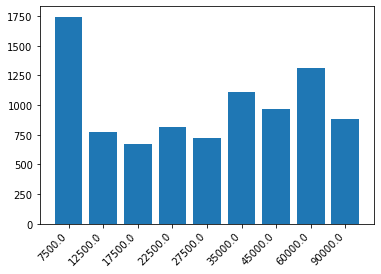

SEX


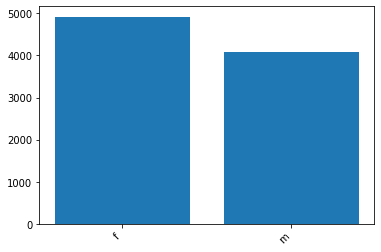

MARITAL_STATUS


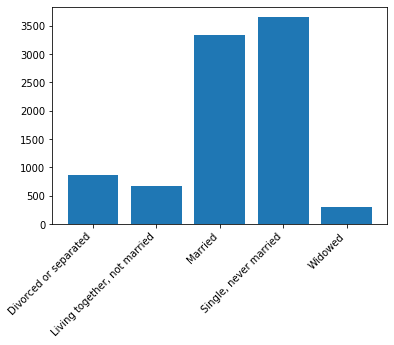

AGE


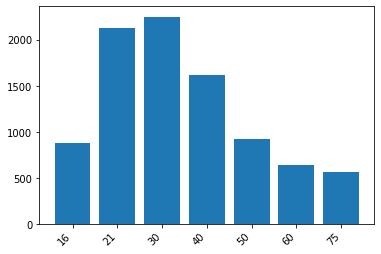

EDUCATION


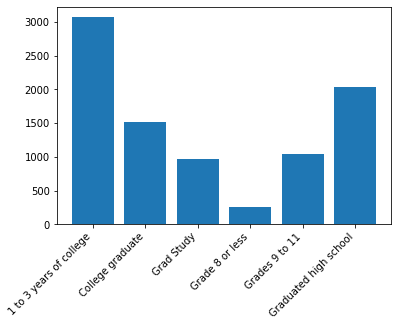

OCCUPATION


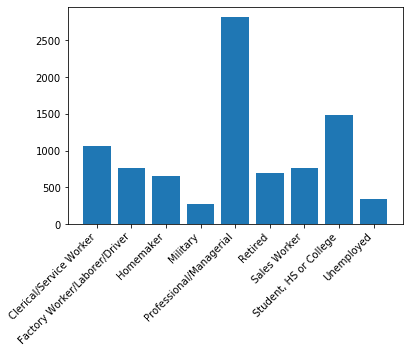

LIVING_PERIOD


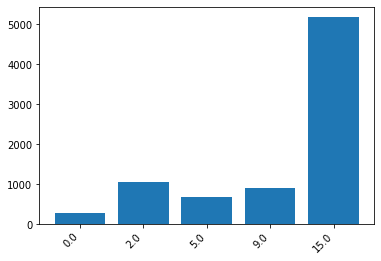

DUAL_INCOMES


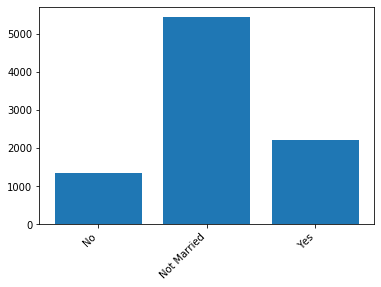

PERSONS_COUNT


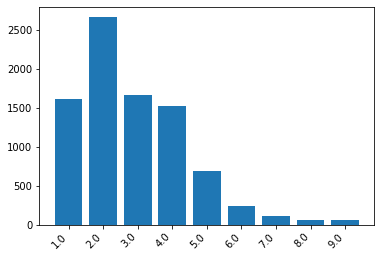

PERSONS_UNDER_18


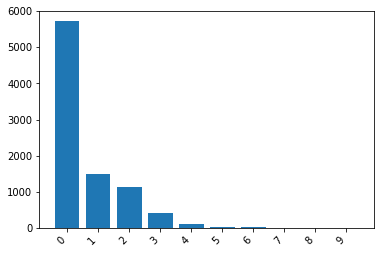

HOUSEHOLDER_STATUS


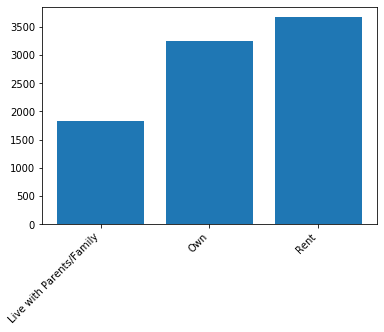

HOME_TYPE


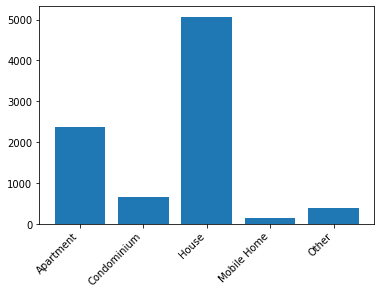

ETHNIC


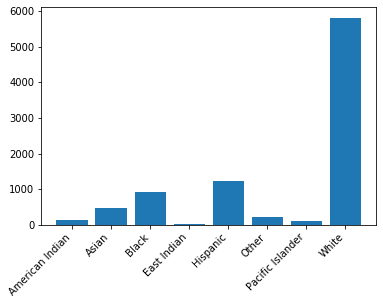

LANGUAGE


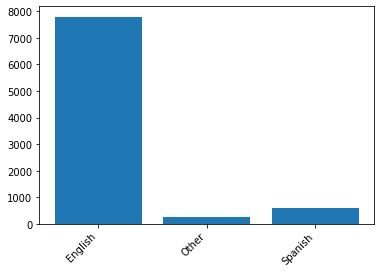

In [9]:
def show_statistic(df: pd.DataFrame) -> None:
    for column in df.columns:
        print(column)
        counts = df[column].value_counts().sort_index()
        
        names = [str(i) for i in counts.index]            
        counts = counts.values
        plt.bar(names, counts)
        plt.xticks(rotation=45, ha="right")
        plt.show()
show_statistic(df2)

    1) Имеем достаточно много одиноких покупателей. Можно предлагать товары, которые упрощают ведение хозяйства.
    2) Получаем, что женщины чаще ходят в наш супермаркет. Может оказаться так, что в семьях чаще покупками занимаются женщины. Стоит посмотреть соотношение одиноких женщин и одиноких мужчин, если и там баланс будет нарушен, значит есть потенциал развития магазина для одного из полов.
    3) Большинство клиентов прожили достаточно долго на одном месте, стоит проверить, являются ли они постоянными покупателями. Если нет - пересмотреть программу лояльности.
    4) Достаточно большое кол-во людей живёт с родителями. Если они достаточно взрослые, то можно предлагать им товары для пожилых.
    5) Много клиентов живут в домах, стоит проверить достаточно ли товаров для придомовой территории: газонокосилки, поливалки, уличная мебель, грили и т.д.
    6) Достаточно много "Испанцев", можно сделать предположение, что на самом деле это Мексиканцы. Можно сделать акцент на национальной кухне.

In [10]:
single_df = df2[(df2["MARITAL_STATUS"] != "Married") & (df2["MARITAL_STATUS"] != "Living together, not married")]
counts = single_df["SEX"].value_counts().sort_index()
print(counts["m"] / counts["f"])
counts = df2["SEX"].value_counts().sort_index()
print(counts["m"] / counts["f"])

0.9233140655105972
0.8287573723815335


Видим, что соотношение одиноких мужчин/женщин ещё ниже. Если посмотреть соотношение полов в США в 1990 году, то увидим, что оно составляет ~0,95. https://www.statista.com/statistics/241495/us-population-by-sex/
Наши значения говорят о том, что есть не раскрытый потенциал для одиноких мужчин. Конечно, многое зависит от способа проведения опроса, что может влиять на выводы. Например, если опрос проводился только один день, а одинокие мужчины закупаются реже.

Посмотрим ещё на распределение по доходу на одного человека.

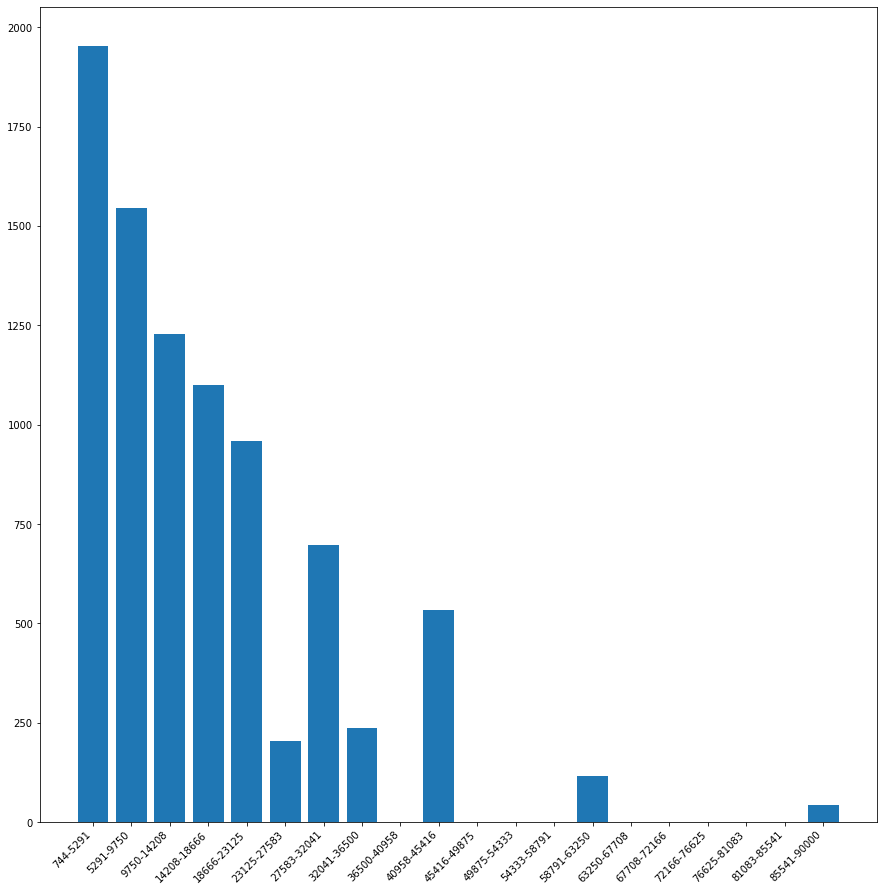

In [11]:
income_per_person = df2["INCOME"] / df2["PERSONS_COUNT"]
counts = income_per_person.value_counts(bins=20).sort_index()
indeces = [str(i.left) + "-" + str(i.right) for i in counts.index]
plt.figure(figsize=(15, 15))
plt.bar([str(int(i.left)) + "-" + str(int(i.right)) for i in counts.index], counts.values)
plt.xticks(rotation=45, ha="right")
plt.show()


Существует группа клиентов, получающих доход на одного человека, который выше, чем средний доход на одного человека в Сан-Франциско в 1987 (~$23700) https://fred.stlouisfed.org/series/PCPI06075 . Стоит рассмотреть их продуктовую корзину. Можно увеличить кол-во более дорогих товаров лучшего качества, если их нет в этой корзине.
При построении модели можно сгенерить фичу на основе кол-ва человек и значении среднего дохода на человека.

In [12]:
corr = df.corr(method="kendall")
corr.style.background_gradient(cmap='coolwarm')

,INCOME,SEX,MARITAL_STATUS,AGE,EDUCATION,OCCUPATION,LIVING_PERIOD,DUAL_INCOMES,PERSONS_COUNT,PERSONS_UNDER_18,HOUSEHOLDER_STATUS,HOME_TYPE,ETHNIC,LANGUAGE
INCOME,1.000000,-0.033502,-0.400526,0.354431,0.367533,-0.300301,0.070292,0.334143,-0.031614,-0.067897,-0.447763,-0.179704,0.106786,-0.104628
SEX,-0.033502,1.000000,-0.086093,0.023776,-0.054851,0.032721,0.061115,0.058828,0.069708,0.088917,-0.038106,-0.033776,0.029919,-0.051268
MARITAL_STATUS,-0.400526,-0.086093,1.000000,-0.463924,-0.206311,0.137749,-0.077944,-0.768416,-0.074109,-0.050131,0.536576,0.146174,-0.069698,0.034735
AGE,0.354431,0.023776,-0.463924,1.000000,0.327337,-0.113517,0.151752,0.382802,-0.233901,-0.217679,-0.588932,-0.076537,0.140501,-0.081401
EDUCATION,0.367533,-0.054851,-0.206311,0.327337,1.000000,-0.320185,-0.051933,0.142359,-0.228967,-0.237988,-0.352178,0.019772,0.139577,-0.140376
OCCUPATION,-0.300301,0.032721,0.137749,-0.113517,-0.320185,1.000000,0.020299,-0.057974,0.092238,0.056636,0.201132,0.005794,-0.050669,0.056624
LIVING_PERIOD,0.070292,0.061115,-0.077944,0.151752,-0.051933,0.020299,1.000000,0.065978,0.060791,0.065164,-0.099493,-0.215025,-0.006966,-0.072069
DUAL_INCOMES,0.334143,0.058828,-0.768416,0.382802,0.142359,-0.057974,0.065978,1.000000,0.127361,0.094764,-0.460196,-0.181326,0.068913,-0.016460
PERSONS_COUNT,-0.031614,0.069708,-0.074109,-0.233901,-0.228967,0.092238,0.060791,0.127361,1.000000,0.614506,0.163913,-0.301630,-0.121592,0.139071
PERSONS_UNDER_18,-0.067897,0.088917,-0.050131,-0.217679,-0.237988,0.056636,0.065164,0.094764,0.614506,1.000000,0.150646,-0.212531,-0.124007,0.095996


Посмотрим на зависимости признаков, особенно на те, которые коррелируют, чтобы понять, как именно они связаны.

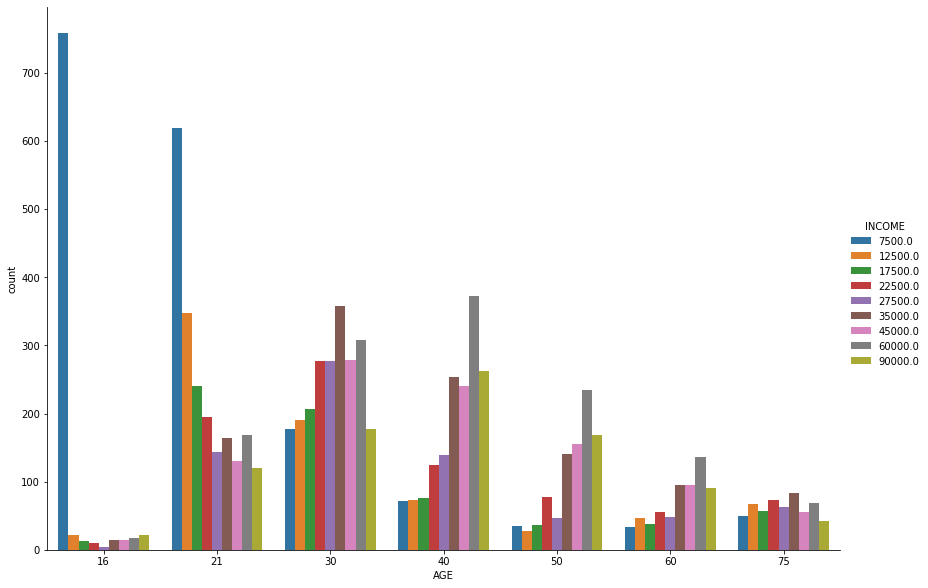

In [13]:
sns.catplot(x="AGE", hue="INCOME", height=8.27, aspect=11.7/8.27, kind="count", data=df2);

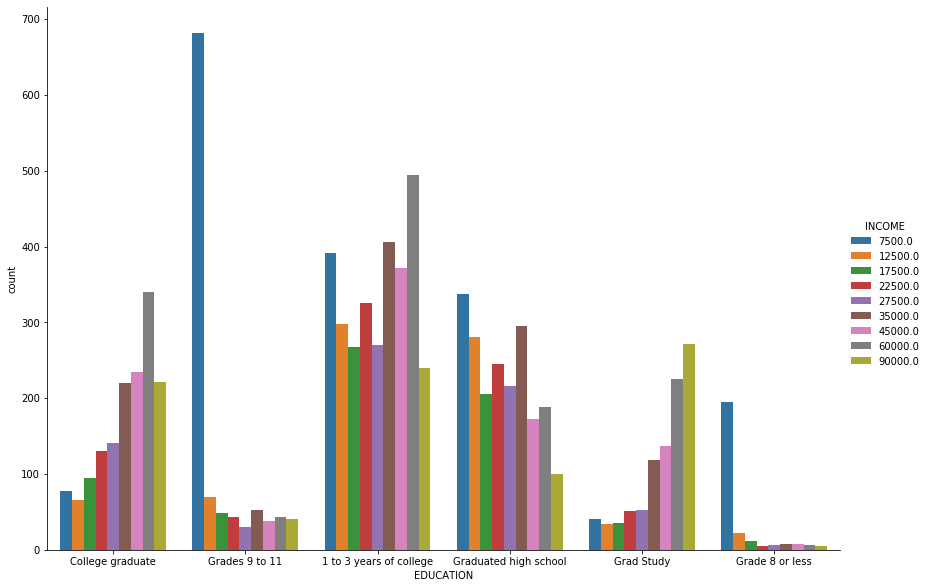

In [14]:
sns.catplot(x="EDUCATION", hue="INCOME", height=8.27, aspect=11.7/8.27, kind="count", data=df2);

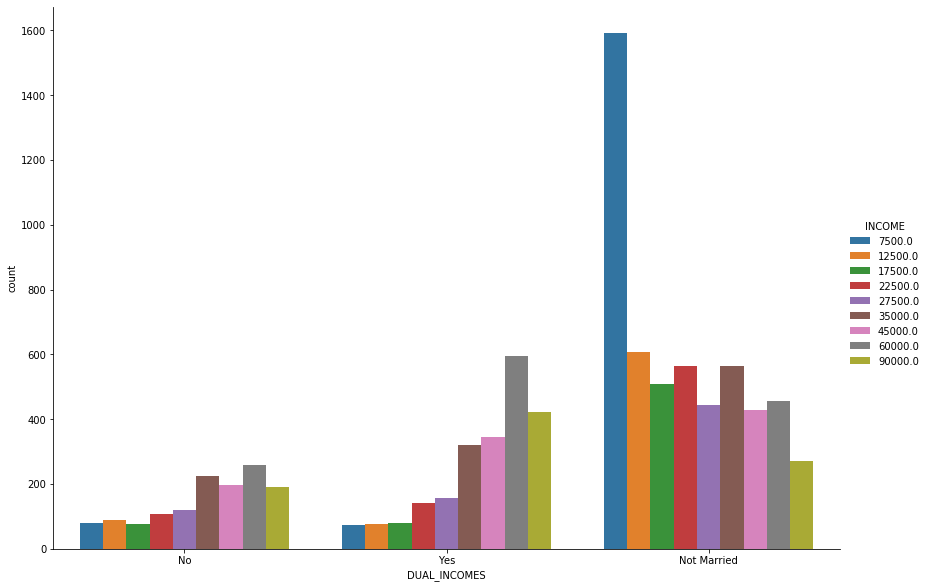

In [15]:
sns.catplot(x="DUAL_INCOMES", hue="INCOME", height=8.27, aspect=11.7/8.27, kind="count", data=df2);

Молодые люди, люди с низким образованием и одинокие люди чаще всего получают небольшой доход, что логично.

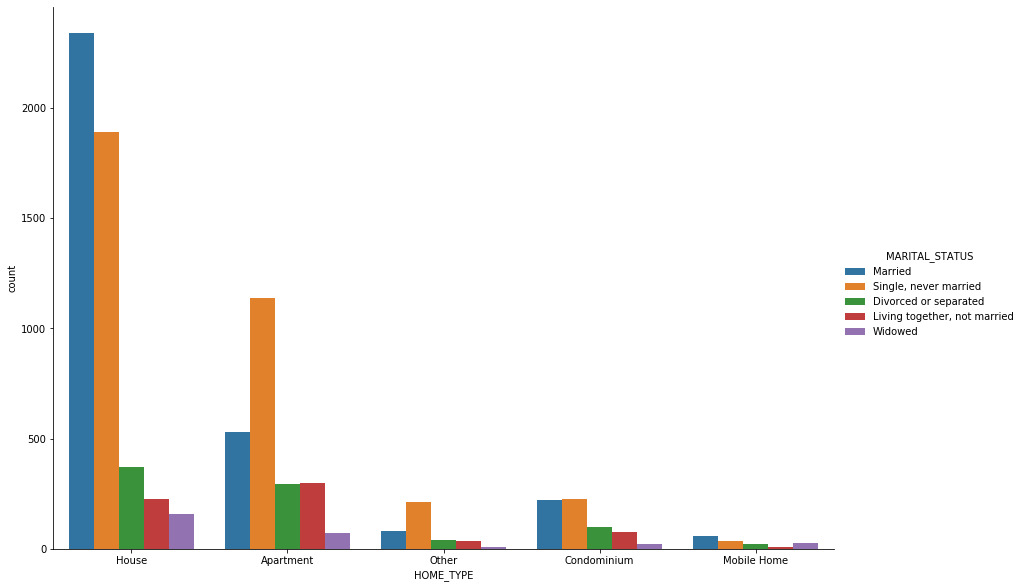

In [16]:
sns.catplot(x="HOME_TYPE", hue="MARITAL_STATUS", height=8.27, aspect=11.7/8.27, kind="count", data=df2);

Женатые пары чаще всего живут в домах. Не совсем понятно, что это даёт бизнесу.

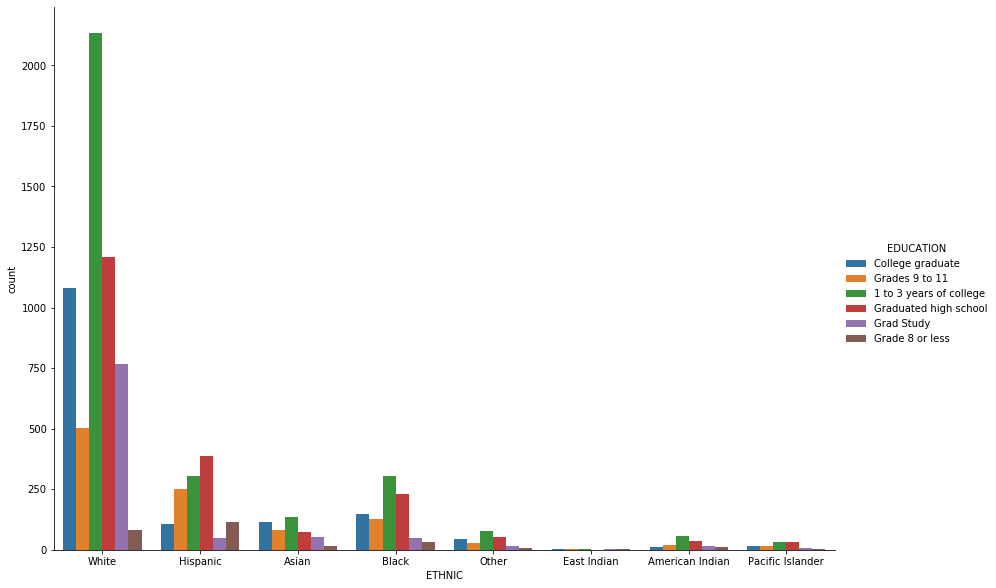

In [17]:
sns.catplot(x="ETHNIC", hue="EDUCATION", height=8.27, aspect=11.7/8.27, kind="count", data=df2);

Белые чаще учатся в колледже. В остальном статистика не сильно отличается.

# Есть ли косяки в данных?
    1) Проверим противоречия в вопросах про замужество
    2) Посмотрим на домохозяйства, полностью состоящие из несовершеннолетних не студентов (это не обязательно косяк, но подозрительно).
    3) Посмотрим на домохозяйства, где было указано, что несовершеннолетних больше, чем всего человек.
    4) Домохозяйства, в которых больше говорят на Испанском, но чувак указал, что он не Испанец. (это не обязательно косяк, но подозрительно)
    5) Молодые люди на пенсии (это не обязательно косяк, но подозрительно)
    6) Выпускники колледжа младше 18 (это не обязательно косяк, но подозрительно)

In [18]:
suspicious_data = df2[
    ((df2["DUAL_INCOMES"] == "Not Married") & (df2["MARITAL_STATUS"] == "Married")) | \
    (df2["PERSONS_UNDER_18"] > df["PERSONS_COUNT"]) | \
    ((df2["PERSONS_UNDER_18"] == df2["PERSONS_COUNT"]) & (df2["OCCUPATION"] != "Student, HS or College")) | \
    ((df2["ETHNIC"] != "Hispanic") & (df2["LANGUAGE"] == "Spanish")) | \
    ((df2["OCCUPATION"] == "Retired") & (df2["AGE"] < 40)) | \
    ((df2["EDUCATION"] == "5") & (df2["AGE"] < 18))
]
suspicious_data

,INCOME,SEX,MARITAL_STATUS,AGE,EDUCATION,OCCUPATION,LIVING_PERIOD,DUAL_INCOMES,PERSONS_COUNT,PERSONS_UNDER_18,HOUSEHOLDER_STATUS,HOME_TYPE,ETHNIC,LANGUAGE
14,45000.0,f,Married,50,1 to 3 years of college,Professional/Managerial,15.0,Yes,2.0,2,Own,House,White,English
53,17500.0,m,Married,16,College graduate,Retired,15.0,Yes,3.0,0,Rent,House,Black,Spanish
63,17500.0,f,Married,50,1 to 3 years of college,Homemaker,NaN,Not Married,4.0,1,Rent,Apartment,Asian,NaN
76,17500.0,f,Married,75,Graduated high school,Homemaker,NaN,No,2.0,2,Own,House,White,English
92,45000.0,f,Married,60,1 to 3 years of college,Homemaker,2.0,Not Married,2.0,0,Own,Other,White,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8609,17500.0,f,Married,30,College graduate,Clerical/Service Worker,5.0,Not Married,2.0,0,Own,House,White,English
8704,7500.0,f,"Single, never married",30,1 to 3 years of college,Clerical/Service Worker,NaN,Not Married,4.0,2,Rent,Condominium,White,Spanish
8776,90000.0,m,"Living together, not married",40,Grad Study,Sales Worker,15.0,Not Married,2.0,0,Own,House,White,Spanish
8828,12500.0,f,Divorced or separated,60,Grad Study,Retired,15.0,Not Married,1.0,1,Rent,Apartment,White,English


In [19]:
suspicious_data.shape[0] / df2.shape[0]

0.029359430604982206

Итого, имеем ~3% подозрительных данных. Можно сказать, что это не очень хороший результат, т.к. мы смогли использовать не самое большое кол-во эвристик для проверки.

# Income.
Попробуем предобработать данные, и загнать их в модель

In [20]:
sum(pd.isnull(df["INCOME"]))

0

Нет пропусков в доходах

In [21]:
features_to_types = {
    "INCOME": "ord",
    "SEX": "bin",
    "MARITAL_STATUS": "cat",
    "AGE": "ord",
    "EDUCATION": "ord",
    "OCCUPATION": "cat",
    "LIVING_PERIOD": "ord",
    "DUAL_INCOMES": "cat",
    "PERSONS_COUNT": "ord",
    "PERSONS_UNDER_18": "ord",
    "HOUSEHOLDER_STATUS": "cat",
    "HOME_TYPE": "cat",
    "ETHNIC": "cat",
    "LANGUAGE": "cat"
}

In [22]:
t = SourceValuesTransformer(columns=modeling_columns)
df2 = t.transform(df)

Создадим трансформер для заполнения пропусков медианой (частым знчением для катег. признаков) и спецсимволом в зависимости от параметра. 

In [23]:
class FillNATransformer(BaseEstimator, TransformerMixin):  
    def __init__(self, features_to_types, method="simple"):
        self.method = method
        self.features_to_types = features_to_types
        
    def fit( self, X, y = None  ):
        return self
   
    def transform(self, X , y = None):
        X = X.copy()
        if self.method == "simple":
            X = X.fillna(-1)
        elif self.method == "median":
            for column in X.columns:
                t = self.features_to_types[column]
                if t == "cat" or t == "bin":
                    X[column] = X[column].fillna(X[column].value_counts().index[0])
                elif t == "ord":
                    X[column] = X[column].fillna(X[column].median())
        return X 

In [24]:
t = FillNATransformer(method="median", features_to_types=features_to_types)
df2 = t.transform(df2)
df2.sample(10)

,INCOME,SEX,MARITAL_STATUS,AGE,EDUCATION,OCCUPATION,LIVING_PERIOD,DUAL_INCOMES,PERSONS_COUNT,PERSONS_UNDER_18,HOUSEHOLDER_STATUS,HOME_TYPE,ETHNIC,LANGUAGE
8919,22500.0,m,"Single, never married",30,3.0,Professional/Managerial,15.0,Not Married,1.0,0,Own,Mobile Home,White,English
3159,35000.0,m,"Single, never married",30,6.0,Professional/Managerial,15.0,Not Married,1.0,0,Rent,Condominium,White,English
4093,60000.0,m,"Single, never married",40,4.0,Professional/Managerial,15.0,Not Married,2.0,0,Own,House,White,English
7785,60000.0,m,"Living together, not married",30,5.0,Professional/Managerial,15.0,Not Married,4.0,1,Rent,Condominium,White,English
375,7500.0,m,"Single, never married",50,4.0,Retired,15.0,Not Married,2.0,0,Rent,House,White,English
910,12500.0,m,Married,60,3.0,Retired,15.0,Yes,2.0,0,Rent,Apartment,White,English
3864,60000.0,m,"Single, never married",21,4.0,Sales Worker,15.0,Not Married,7.0,2,Live with Parents/Family,House,Pacific Islander,English
3357,35000.0,f,Married,50,3.0,Clerical/Service Worker,15.0,Yes,6.0,1,Rent,House,White,English
4030,22500.0,f,Divorced or separated,40,3.0,Professional/Managerial,15.0,Not Married,2.0,0,Rent,House,White,English
159,90000.0,m,Married,75,6.0,Professional/Managerial,15.0,No,3.0,3,Own,House,White,English


Создадим трансформер для One-Hot-Encoding для бинарных и категориальных признаков.

In [25]:
class EncodeValuesTransformer(BaseEstimator, TransformerMixin):  
    def __init__(self, features_to_types):
        self.features_to_types = features_to_types
        
    def fit( self, X, y = None):
        return self
   
    def transform(self, X , y = None):
        X = X.copy()
        for column in X.columns:
            if column in self.features_to_types:
                t = self.features_to_types[column]
                if t == "cat" or t == "bin":
                    X = pd.concat([X.drop(column, axis=1), pd.get_dummies(X[column], prefix=column + "_is")], axis=1)
        return X 

In [26]:
t = EncodeValuesTransformer(features_to_types=features_to_types)
df2 = t.transform(df2)
df2

,INCOME,AGE,EDUCATION,LIVING_PERIOD,PERSONS_COUNT,PERSONS_UNDER_18,SEX_is_f,SEX_is_m,MARITAL_STATUS_is_Divorced or separated,"MARITAL_STATUS_is_Living together, not married",MARITAL_STATUS_is_Married,"MARITAL_STATUS_is_Single, never married",MARITAL_STATUS_is_Widowed,OCCUPATION_is_Clerical/Service Worker,OCCUPATION_is_Factory Worker/Laborer/Driver,OCCUPATION_is_Homemaker,OCCUPATION_is_Military,OCCUPATION_is_Professional/Managerial,OCCUPATION_is_Retired,OCCUPATION_is_Sales Worker,"OCCUPATION_is_Student, HS or College",OCCUPATION_is_Unemployed,DUAL_INCOMES_is_No,DUAL_INCOMES_is_Not Married,DUAL_INCOMES_is_Yes,HOUSEHOLDER_STATUS_is_Live with Parents/Family,HOUSEHOLDER_STATUS_is_Own,HOUSEHOLDER_STATUS_is_Rent,HOME_TYPE_is_Apartment,HOME_TYPE_is_Condominium,HOME_TYPE_is_House,HOME_TYPE_is_Mobile Home,HOME_TYPE_is_Other,ETHNIC_is_American Indian,ETHNIC_is_Asian,ETHNIC_is_Black,ETHNIC_is_East Indian,ETHNIC_is_Hispanic,ETHNIC_is_Other,ETHNIC_is_Pacific Islander,ETHNIC_is_White,LANGUAGE_is_English,LANGUAGE_is_Other,LANGUAGE_is_Spanish
0,90000.0,50,5.0,15.0,5.0,2,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
1,90000.0,30,5.0,15.0,3.0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,7500.0,16,2.0,15.0,4.0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
3,7500.0,16,2.0,5.0,4.0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
4,60000.0,60,4.0,15.0,2.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8987,7500.0,16,1.0,15.0,3.0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
8988,12500.0,21,4.0,15.0,4.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
8989,7500.0,16,2.0,15.0,3.0,2,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
8990,22500.0,60,4.0,15.0,3.0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


Попробуем добавить новые признаки.

In [27]:
class NewFeaturesTransformer(BaseEstimator, TransformerMixin):  
    def __init__(self, features):
        self.features = features
        
    def fit( self, X, y = None):
        return self
   
    def transform(self, X , y = None):
        X = X.copy()
        if "PERSONS_OLDER_18" in self.features:
            X["PERSONS_OLDER_18"] = X["PERSONS_COUNT"] - X["PERSONS_UNDER_18"]
        if "MEAN_INCOME" in self.features:
            X["MEAN_INCOME"] = (X["PERSONS_OLDER_18"] + X["PERSONS_UNDER_18"]*0.3)*20000
        return X

In [28]:
t = NewFeaturesTransformer(features=set(["PERSONS_OLDER_18", "MEAN_INCOME"]))
df2 = t.transform(df2)
df2

,INCOME,AGE,EDUCATION,LIVING_PERIOD,PERSONS_COUNT,PERSONS_UNDER_18,SEX_is_f,SEX_is_m,MARITAL_STATUS_is_Divorced or separated,"MARITAL_STATUS_is_Living together, not married",MARITAL_STATUS_is_Married,"MARITAL_STATUS_is_Single, never married",MARITAL_STATUS_is_Widowed,OCCUPATION_is_Clerical/Service Worker,OCCUPATION_is_Factory Worker/Laborer/Driver,OCCUPATION_is_Homemaker,OCCUPATION_is_Military,OCCUPATION_is_Professional/Managerial,OCCUPATION_is_Retired,OCCUPATION_is_Sales Worker,"OCCUPATION_is_Student, HS or College",OCCUPATION_is_Unemployed,DUAL_INCOMES_is_No,DUAL_INCOMES_is_Not Married,DUAL_INCOMES_is_Yes,HOUSEHOLDER_STATUS_is_Live with Parents/Family,HOUSEHOLDER_STATUS_is_Own,HOUSEHOLDER_STATUS_is_Rent,HOME_TYPE_is_Apartment,HOME_TYPE_is_Condominium,HOME_TYPE_is_House,HOME_TYPE_is_Mobile Home,HOME_TYPE_is_Other,ETHNIC_is_American Indian,ETHNIC_is_Asian,ETHNIC_is_Black,ETHNIC_is_East Indian,ETHNIC_is_Hispanic,ETHNIC_is_Other,ETHNIC_is_Pacific Islander,ETHNIC_is_White,LANGUAGE_is_English,LANGUAGE_is_Other,LANGUAGE_is_Spanish,PERSONS_OLDER_18,MEAN_INCOME
0,90000.0,50,5.0,15.0,5.0,2,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,3.0,72000.0
1,90000.0,30,5.0,15.0,3.0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2.0,46000.0
2,7500.0,16,2.0,15.0,4.0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,2.0,52000.0
3,7500.0,16,2.0,5.0,4.0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,2.0,52000.0
4,60000.0,60,4.0,15.0,2.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,2.0,40000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8987,7500.0,16,1.0,15.0,3.0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1.0,32000.0
8988,12500.0,21,4.0,15.0,4.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,4.0,80000.0
8989,7500.0,16,2.0,15.0,3.0,2,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1.0,32000.0
8990,22500.0,60,4.0,15.0,3.0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2.0,46000.0


In [29]:
class DFToValuesTransformer(BaseEstimator, TransformerMixin):  
    def __init__(self):
        pass
        
    def fit( self, X, y = None):
        return self
   
    def transform(self, X , y = None):
        return X.values

In [30]:
y = df2["INCOME"].to_numpy()
X = df.drop("INCOME", axis=1)

pipeline = Pipeline([
    ("source_values_transformer", SourceValuesTransformer(modeling_columns)),
    ("fill_na_transformer", FillNATransformer(features_to_types, method="simple")),
    ("encode_values_transformer", EncodeValuesTransformer(features_to_types)),
    ("new_features_transformer", NewFeaturesTransformer(features=set())),
#     ("df_to_values_transformer", DFToValuesTransformer()),
    ("classifier", XGBClassifier())
])


params = {
    "source_values_transformer__columns": [modeling_columns],
    "fill_na_transformer__method": ["simple", "median"],
    "fill_na_transformer__features_to_types": [features_to_types],
    "encode_values_transformer__features_to_types": [features_to_types],
    "new_features_transformer__features": [
        [],
        ["PERSONS_OLDER_18"],
        ["PERSONS_OLDER_18", "MEAN_INCOME"]
    ],
    "classifier__max_depth": list(range(1, 10)),
    "classifier__n_jobs": [4],
    "classifier__n_estimators": [10, 20, 50, 110]
}
gs = GridSearchCV(estimator=pipeline, param_grid=params , scoring="f1_micro")
gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('source_values_transformer',
                                        SourceValuesTransformer(columns={'AGE',
                                                                         'DUAL_INCOMES',
                                                                         'ETHNIC',
                                                                         'HOME_TYPE',
                                                                         'HOUSEHOLDER_STATUS',
                                                                         'INCOME',
                                                                         'LANGUAGE',
                                                                         'LIVING_PERIOD',
                                                                         'MARITAL_STATUS',
                                                                         'OCCUPATION',
                                                              

In [31]:
gs.best_params_, gs.best_score_

({'classifier__max_depth': 4,
  'classifier__n_estimators': 50,
  'classifier__n_jobs': 4,
  'encode_values_transformer__features_to_types': {'INCOME': 'ord',
   'SEX': 'bin',
   'MARITAL_STATUS': 'cat',
   'AGE': 'ord',
   'EDUCATION': 'ord',
   'OCCUPATION': 'cat',
   'LIVING_PERIOD': 'ord',
   'DUAL_INCOMES': 'cat',
   'PERSONS_COUNT': 'ord',
   'PERSONS_UNDER_18': 'ord',
   'HOUSEHOLDER_STATUS': 'cat',
   'HOME_TYPE': 'cat',
   'ETHNIC': 'cat',
   'LANGUAGE': 'cat'},
  'fill_na_transformer__features_to_types': {'INCOME': 'ord',
   'SEX': 'bin',
   'MARITAL_STATUS': 'cat',
   'AGE': 'ord',
   'EDUCATION': 'ord',
   'OCCUPATION': 'cat',
   'LIVING_PERIOD': 'ord',
   'DUAL_INCOMES': 'cat',
   'PERSONS_COUNT': 'ord',
   'PERSONS_UNDER_18': 'ord',
   'HOUSEHOLDER_STATUS': 'cat',
   'HOME_TYPE': 'cat',
   'ETHNIC': 'cat',
   'LANGUAGE': 'cat'},
  'fill_na_transformer__method': 'median',
  'new_features_transformer__features': [],
  'source_values_transformer__columns': {'AGE',
   'DUAL_I

In [32]:
clf = gs.best_estimator_
clf.predict(X)

array([60000., 60000.,  7500., ...,  7500., 45000., 27500.])

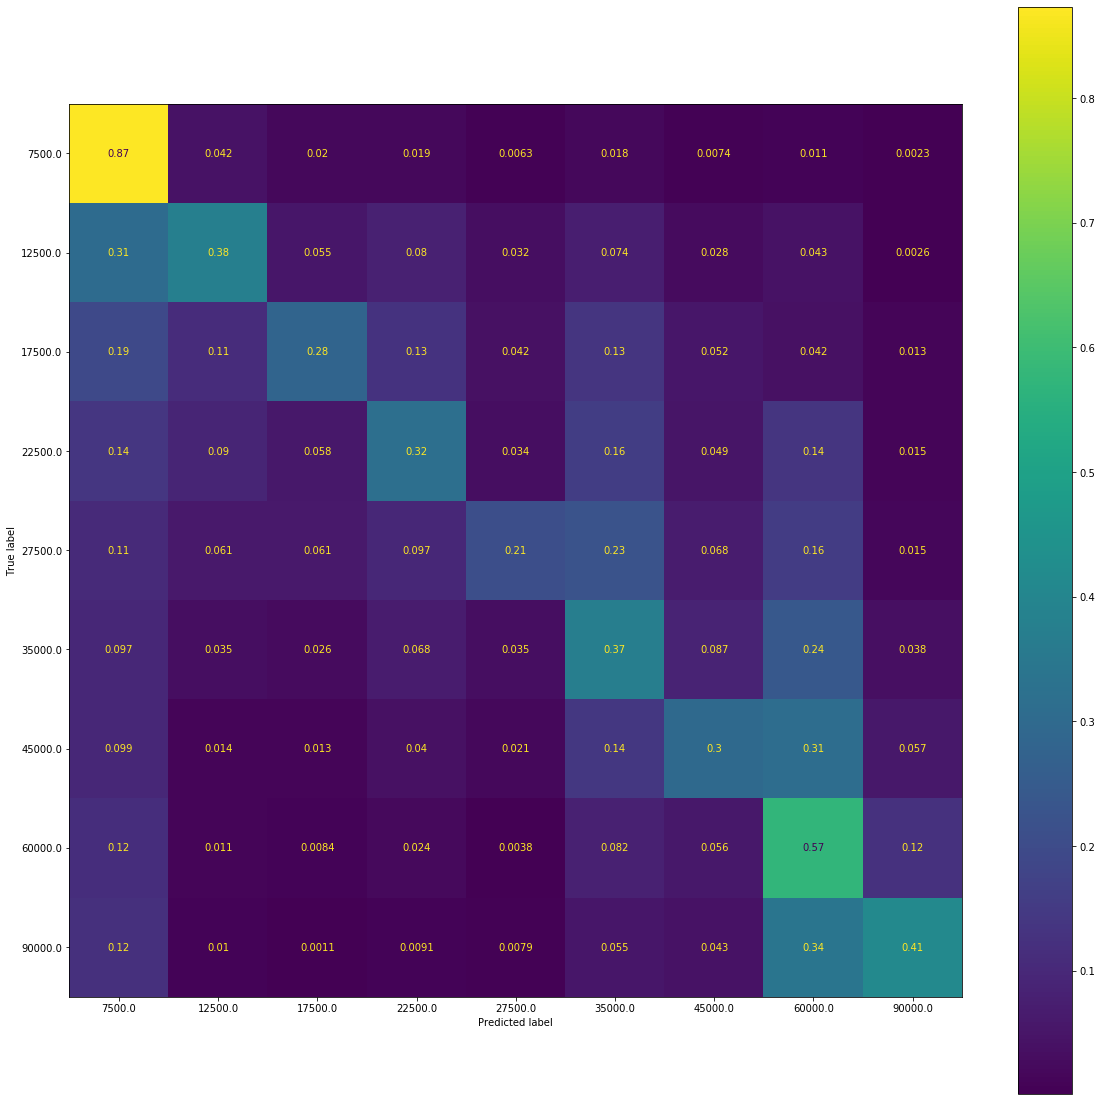

In [33]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(clf, X, y, normalize="true", ax=ax)

Видно, что для некоторых значений ошибки появляются в соседних интервалах. Тогда встаёт вопрос о более мягком подсчёте ошибок. Насколько страшно для бизнеса промахнуться на один интервал? Можно так же перейти к задаче регрессии.

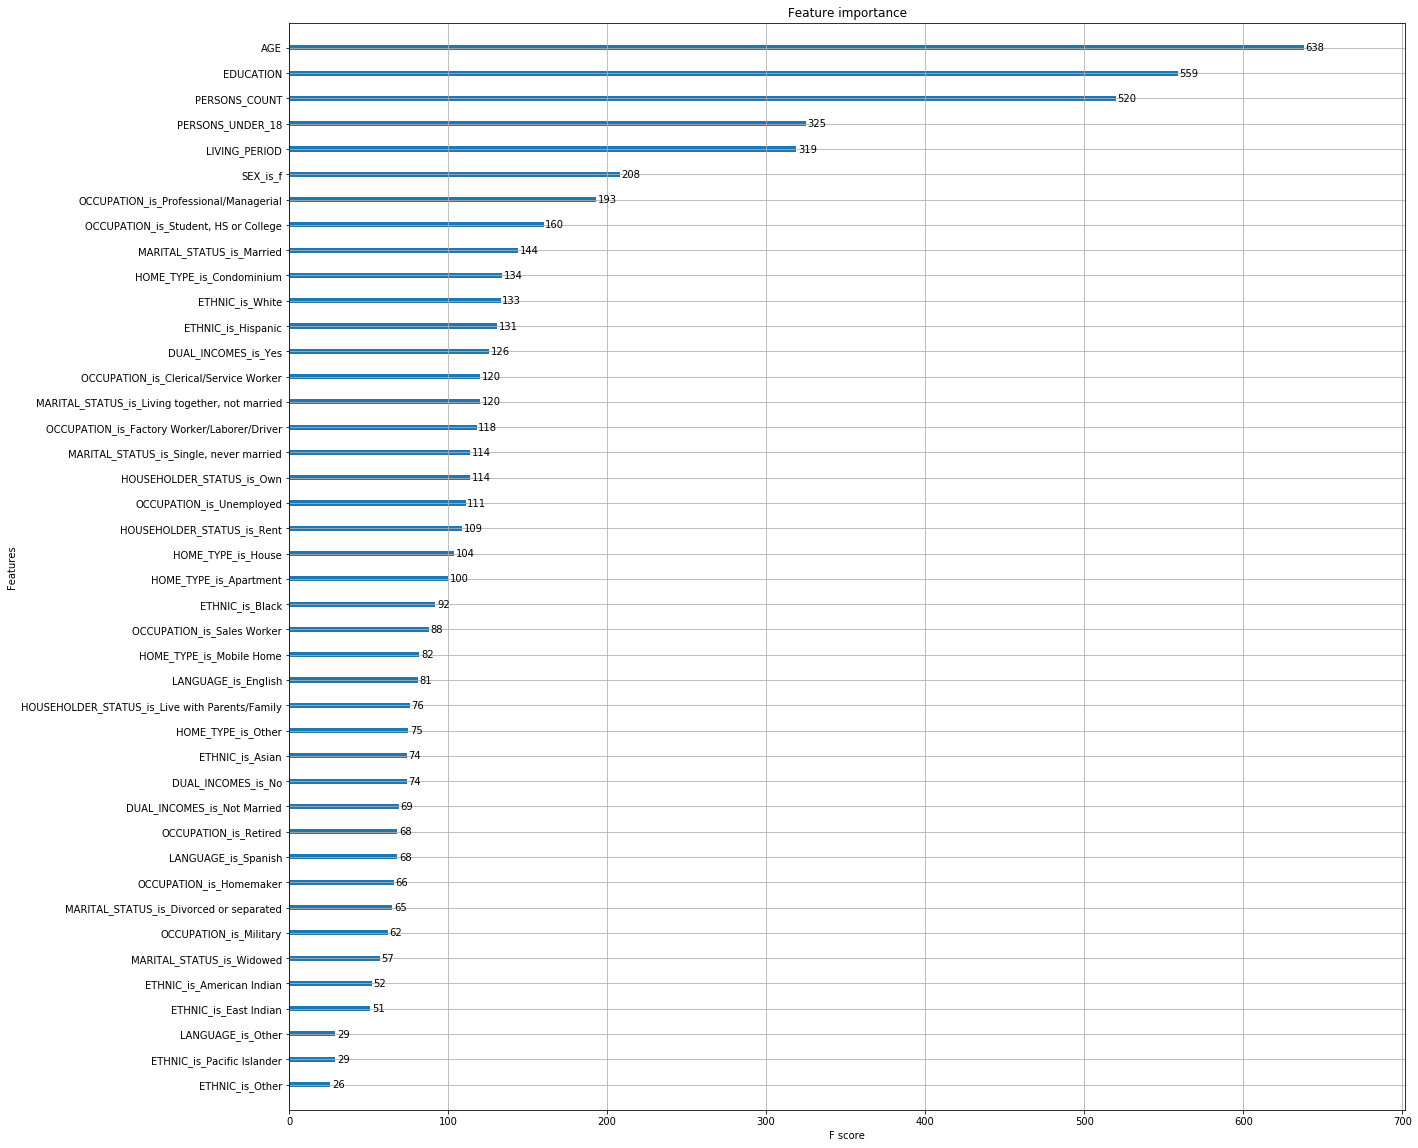

In [34]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(clf["classifier"], ax=ax)
plt.show()

Важные фичи оказались схожи с теми, что были выявлены на стадии визуализации.

# Income. Заключение
Стоит уточнить задачу с точки зрения бизнеса, насколько уместно переходить к задаче регрессии. Следует ещё поработать с генерацией новых фич (featuretools).

# Occupation
Проделаем те же шаги для определения рода деятельности

In [35]:
sum(pd.isnull(df["OCCUPATION"]))

136

Есть экземпляры с пропусками, следует их убрать из выборки.

In [36]:
df_occupation = df[~pd.isnull(df["OCCUPATION"])]
df_occupation

,INCOME,SEX,MARITAL_STATUS,AGE,EDUCATION,OCCUPATION,LIVING_PERIOD,DUAL_INCOMES,PERSONS_COUNT,PERSONS_UNDER_18,HOUSEHOLDER_STATUS,HOME_TYPE,ETHNIC,LANGUAGE
0,9,1,1.0,5,5.0,5.0,5.0,3,5.0,2,1.0,1.0,7.0,1.0
1,9,2,1.0,3,5.0,1.0,5.0,2,3.0,1,2.0,3.0,7.0,1.0
2,1,2,5.0,1,2.0,6.0,5.0,1,4.0,2,3.0,1.0,7.0,1.0
3,1,2,5.0,1,2.0,6.0,3.0,1,4.0,2,3.0,1.0,7.0,1.0
4,8,1,1.0,6,4.0,8.0,5.0,3,2.0,0,1.0,1.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8987,1,2,5.0,1,1.0,2.0,5.0,1,3.0,2,3.0,1.0,7.0,1.0
8988,2,1,5.0,2,4.0,1.0,5.0,1,4.0,0,3.0,1.0,7.0,1.0
8989,1,2,5.0,1,2.0,1.0,5.0,1,3.0,2,3.0,1.0,7.0,1.0
8990,4,1,1.0,6,4.0,3.0,5.0,2,3.0,1,2.0,3.0,7.0,1.0


In [37]:
class OccupationNewFeaturesTransformer(BaseEstimator, TransformerMixin):  
    def __init__(self, features):
        self.features = features
        
    def fit( self, X, y = None):
        return self
   
    def transform(self, X , y = None):
        X = X.copy()
        if "PERSONS_OLDER_18" in self.features:
            X["PERSONS_OLDER_18"] = X["PERSONS_COUNT"] - X["PERSONS_UNDER_18"]
        if "MEAN_INCOME" in self.features:
            X["MEAN_INCOME"] = X["INCOME"]*X["EDUCATION"]/(X["PERSONS_OLDER_18"] + X["PERSONS_UNDER_18"]*0.3)
        return X

In [38]:
t =  SourceValuesTransformer(modeling_columns)
y = t.transform(df_occupation)["OCCUPATION"].to_numpy()
X = df_occupation.drop("OCCUPATION", axis=1)

pipeline = Pipeline([
    ("source_values_transformer", SourceValuesTransformer(modeling_columns)),
    ("fill_na_transformer", FillNATransformer(features_to_types, method="simple")),
    ("encode_values_transformer", EncodeValuesTransformer(features_to_types)),
    ("new_features_transformer", OccupationNewFeaturesTransformer(features=set())),
#     ("df_to_values_transformer", DFToValuesTransformer()),
    ("classifier", XGBClassifier())
])


params = {
    "source_values_transformer__columns": [modeling_columns],
    "fill_na_transformer__method": ["simple", "median"],
    "fill_na_transformer__features_to_types": [features_to_types],
    "encode_values_transformer__features_to_types": [features_to_types],
    "new_features_transformer__features": [
        [],
        ["PERSONS_OLDER_18"],
        ["PERSONS_OLDER_18", "MEAN_INCOME"]
    ],
    "classifier__max_depth": list(range(1, 10)),
    "classifier__n_jobs": [4],
    "classifier__n_estimators": [10, 20, 50, 110]
}
gs = GridSearchCV(estimator=pipeline, param_grid=params , scoring="f1_micro")
gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('source_values_transformer',
                                        SourceValuesTransformer(columns={'AGE',
                                                                         'DUAL_INCOMES',
                                                                         'ETHNIC',
                                                                         'HOME_TYPE',
                                                                         'HOUSEHOLDER_STATUS',
                                                                         'INCOME',
                                                                         'LANGUAGE',
                                                                         'LIVING_PERIOD',
                                                                         'MARITAL_STATUS',
                                                                         'OCCUPATION',
                                                              

In [39]:
gs.best_params_, gs.best_score_

({'classifier__max_depth': 4,
  'classifier__n_estimators': 20,
  'classifier__n_jobs': 4,
  'encode_values_transformer__features_to_types': {'INCOME': 'ord',
   'SEX': 'bin',
   'MARITAL_STATUS': 'cat',
   'AGE': 'ord',
   'EDUCATION': 'ord',
   'OCCUPATION': 'cat',
   'LIVING_PERIOD': 'ord',
   'DUAL_INCOMES': 'cat',
   'PERSONS_COUNT': 'ord',
   'PERSONS_UNDER_18': 'ord',
   'HOUSEHOLDER_STATUS': 'cat',
   'HOME_TYPE': 'cat',
   'ETHNIC': 'cat',
   'LANGUAGE': 'cat'},
  'fill_na_transformer__features_to_types': {'INCOME': 'ord',
   'SEX': 'bin',
   'MARITAL_STATUS': 'cat',
   'AGE': 'ord',
   'EDUCATION': 'ord',
   'OCCUPATION': 'cat',
   'LIVING_PERIOD': 'ord',
   'DUAL_INCOMES': 'cat',
   'PERSONS_COUNT': 'ord',
   'PERSONS_UNDER_18': 'ord',
   'HOUSEHOLDER_STATUS': 'cat',
   'HOME_TYPE': 'cat',
   'ETHNIC': 'cat',
   'LANGUAGE': 'cat'},
  'fill_na_transformer__method': 'simple',
  'new_features_transformer__features': [],
  'source_values_transformer__columns': {'AGE',
   'DUAL_I

In [40]:
clf = gs.best_estimator_
clf.predict(X)

array(['Professional/Managerial', 'Professional/Managerial',
       'Student, HS or College', ..., 'Student, HS or College',
       'Professional/Managerial', 'Professional/Managerial'], dtype=object)

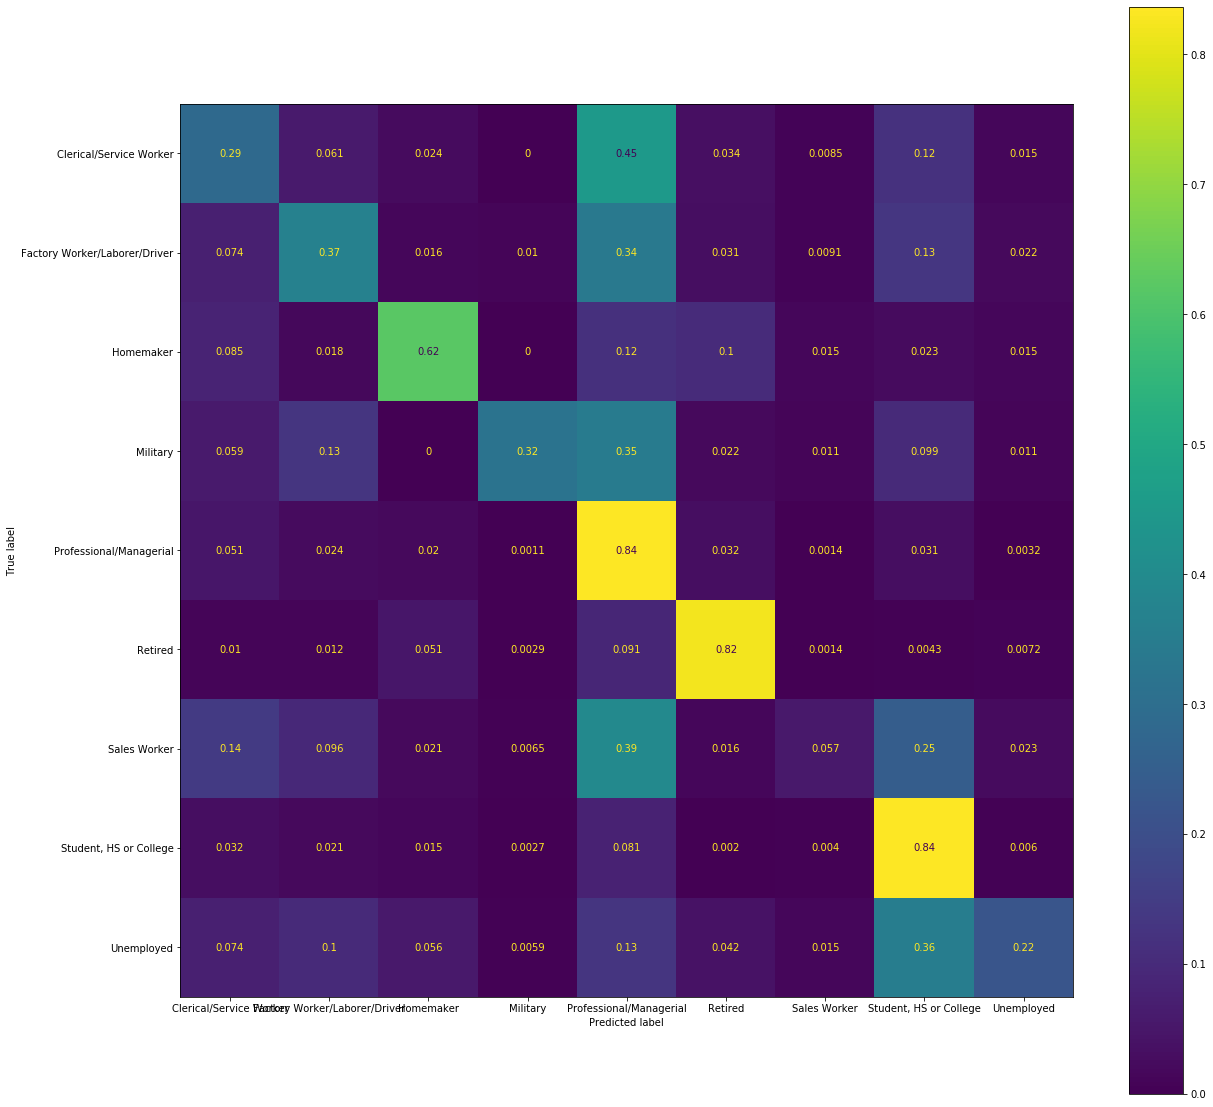

In [41]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(clf, X, y, normalize="true", ax=ax)

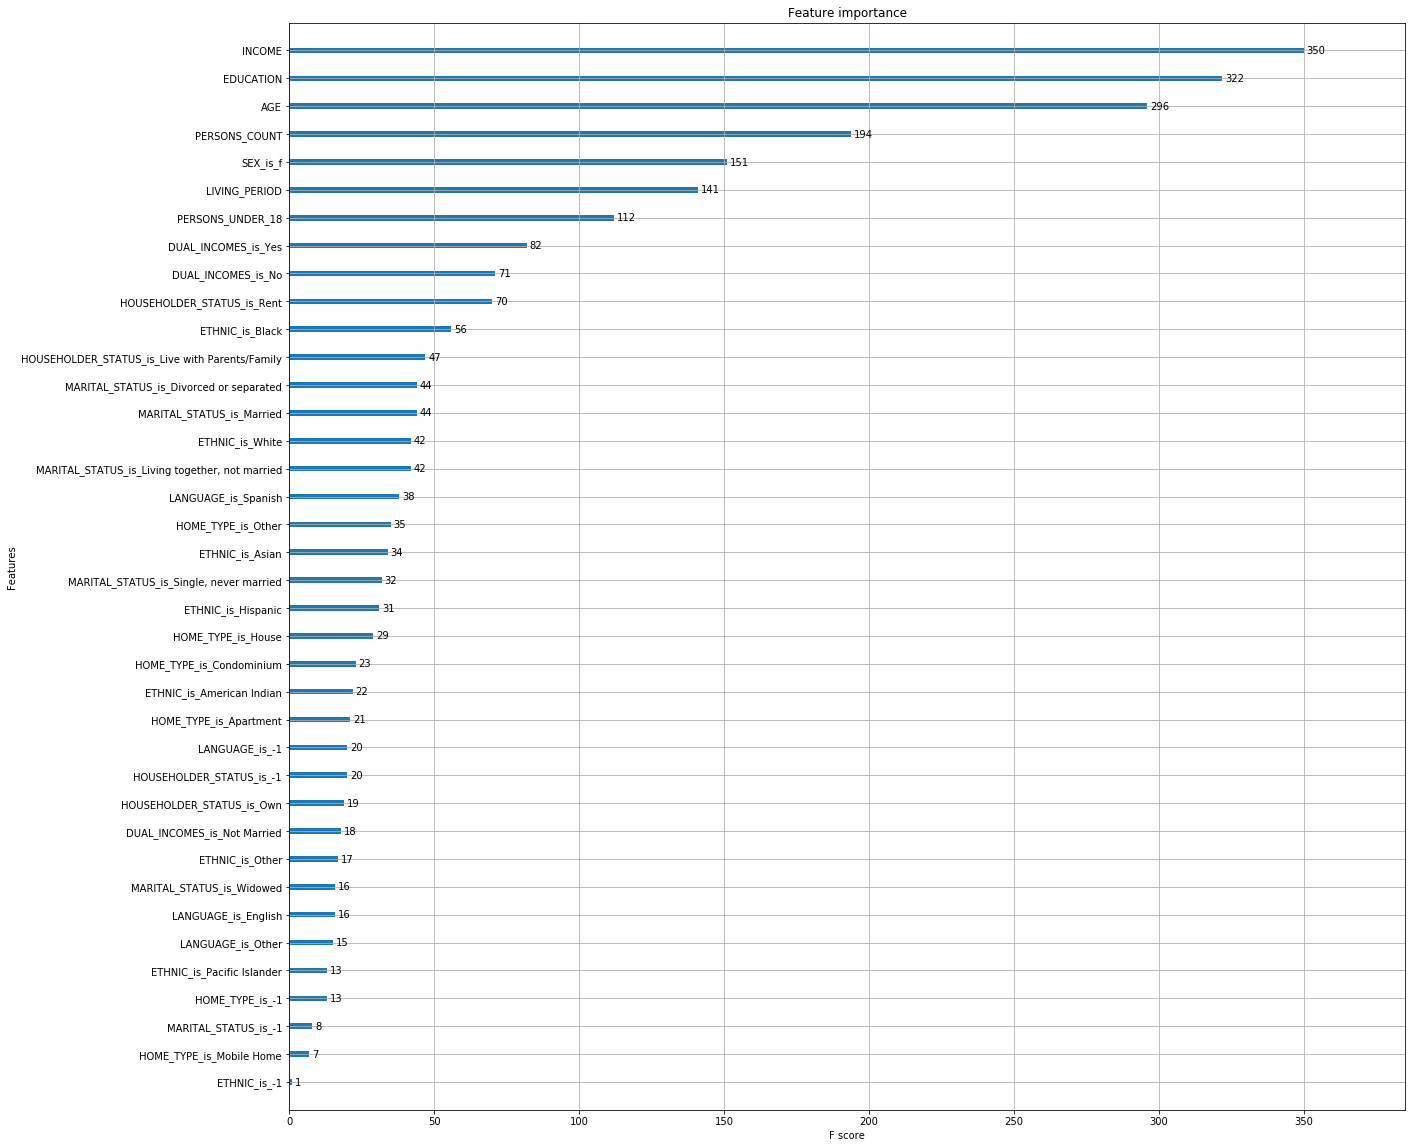

In [42]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(clf["classifier"], ax=ax)
plt.show()

# Occupation. Заключение
Стоит поработать с балансом классов, однако XGBoost поддерживает только вес экземпляров, что создаёт сложности при совмещении с кросс-валидацией. Это может помочь уменьшить кол-во ошибок на доминирующих классах "Professional/Managerial" и "Student, HS or College" 